In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import scipy.stats as stats
import model

from sklearn.cluster import KMeans

In [2]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWIN, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

In [3]:
X_train_scaled

,parcelid,bathrooms,bedrooms,condition,sq_ft,full_baths,latitude,longitude,lot_size,census_tract,...,age,sq_ft_per_bathroom,sq_ft_per_bedroom,sq_ft_per_room,has_half_bath,tax_rate,price_per_sq_ft,Los_Angeles,Orange,Ventura
0,0.000849,0.333333,0.333333,0.454545,0.515721,0.5,0.573098,0.520347,0.001129,0.000365,...,0.584,0.494556,0.366901,0.587500,0.0,0.544719,0.161422,1.0,0.0,0.0
1,0.024477,1.000000,1.000000,0.454545,0.890830,1.0,0.076040,0.966372,0.001715,0.296869,...,0.208,0.494137,0.254749,0.907011,0.0,0.140196,0.492855,0.0,1.0,0.0
2,0.021369,0.333333,0.666667,0.454545,0.326638,0.5,0.269144,0.773711,0.000927,0.297648,...,0.392,0.313233,0.142510,0.074527,0.0,0.564074,0.355375,0.0,1.0,0.0
3,0.012255,0.333333,0.666667,0.454545,0.455459,0.5,0.343177,0.629829,0.000771,0.005983,...,0.384,0.436767,0.193685,0.536170,0.0,0.580565,0.346178,1.0,0.0,0.0
4,0.011818,0.333333,0.333333,0.636364,0.211354,0.5,0.300060,0.686613,0.001390,0.006411,...,0.280,0.202680,0.185532,0.328246,0.0,0.413904,0.602933,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22156,0.013912,0.333333,0.666667,0.454545,0.453275,0.5,0.408222,0.772092,0.001340,0.005400,...,0.480,0.434673,0.192818,0.534310,0.0,0.469528,0.422891,1.0,0.0,0.0
22157,0.021939,0.666667,1.000000,0.454545,0.986900,0.5,0.230682,0.770133,0.000904,0.297642,...,0.384,0.711893,0.283372,0.131659,1.0,0.351378,0.290606,0.0,1.0,0.0
22158,0.007112,0.333333,0.333333,0.454545,0.219214,0.5,0.477261,0.630094,0.019765,0.001420,...,0.080,0.210218,0.190216,0.334942,0.0,0.411003,0.794560,1.0,0.0,0.0
22159,0.002819,0.333333,0.333333,0.636364,0.193450,0.5,0.698763,0.478926,0.091468,0.011084,...,0.200,0.185511,0.174863,0.312996,0.0,0.811826,0.446185,1.0,0.0,0.0


# CLUSTERING ON THE FOLLOWING VARIABLES:
- sq_ft, price_per_sq_ft, tax_rate


In [4]:
# X_train_scaled.head().T

Step 1: get your k

In [5]:
# list of variables I will cluster on. 
cluster_vars = ['sq_ft', 'price_per_sq_ft', 'tax_rate']
cluster_name = 'good_deal_or_not_?'
k_range = range(2,20)

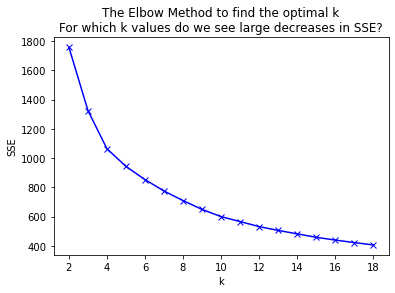

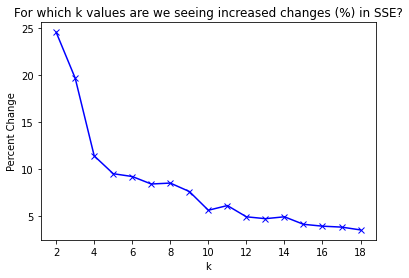

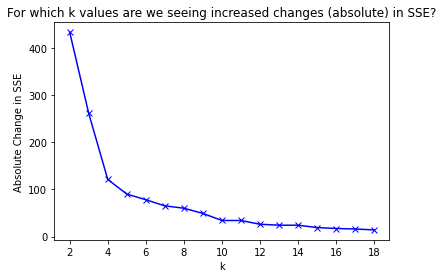

,k,sse,delta,pct_delta
0,2,1757.429884,433.0,24.6
1,3,1324.616869,261.0,19.7
2,4,1063.289462,121.0,11.4
3,5,942.284979,90.0,9.5
4,6,852.410669,78.0,9.2
5,7,774.192719,65.0,8.4
6,8,708.944409,60.0,8.5
7,9,648.527709,49.0,7.6
8,10,599.231989,34.0,5.6
9,11,565.381670,34.0,6.1


In [6]:
model.find_k(X_train_scaled, cluster_vars, k_range)

# Looks like k=5 seems happy

In [7]:
k = 5

Step 2: create kmeans object and fit

In [8]:
kmeans = model.create_clusters(X_train_scaled, k, cluster_vars)

Step 3: get centroids

In [9]:
centroid_df = model.get_centroids(kmeans, cluster_vars, cluster_name)

Step 4: label observations and append to EACH?? X dataframe : (

In [10]:
test_df = X_train_scaled.copy()

In [11]:
centroid_df

,good_deal_or_not_?,centroid_sq_ft,centroid_price_per_sq_ft,centroid_tax_rate
0,0,0.355665,0.353695,0.480207
1,1,0.729038,0.468711,0.396755
2,2,0.396411,0.458085,0.224684
3,3,0.347529,0.690335,0.464534
4,4,0.515540,0.300010,0.784879


In [12]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len([X_train_scaled,X_validate_scaled,X_test_scaled])):
        clusters = pd.DataFrame(kmeans.predict([X_train_scaled,X_validate_scaled,X_test_scaled][i][cluster_vars]), 
                            columns=[cluster_name], index=[X_train_scaled,X_validate_scaled,X_test_scaled][i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        [X_train_scaled,X_validate_scaled,X_test_scaled][i] = pd.concat([[X_train_scaled,X_validate_scaled,X_test_scaled][i], clusters_centroids], axis=1)
    return X_train_scaled,X_validate_scaled,X_test_scaled

In [13]:
X_train_scaled,X_validate_scaled,X_test_scaled = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

## I'm having an awful hard time getting the above to work, so I'm going to try another method....

In [14]:
# define independent variables for k-means

deal_cluster_df = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

array([[<AxesSubplot:title={'center':'sq_ft'}>,
        <AxesSubplot:title={'center':'price_per_sq_ft'}>],
       [<AxesSubplot:title={'center':'tax_rate'}>, <AxesSubplot:>]],
      dtype=object)

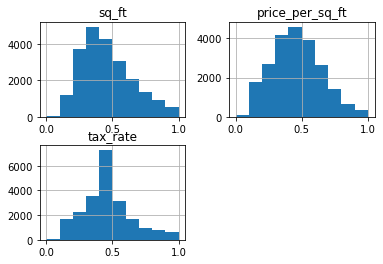

In [15]:
deal_cluster_df.hist()

### cluster_df is already scaled

In [16]:
deal_cluster_df.describe()

,sq_ft,price_per_sq_ft,tax_rate
count,22161.000000,22161.000000,22161.000000
mean,0.458257,0.461773,0.461108
std,0.192961,0.185600,0.184500
min,0.000000,0.000000,0.000000
25%,0.310917,0.325836,0.354157
50%,0.426201,0.452259,0.446139
75%,0.579039,0.584635,0.543354
max,1.000000,1.000000,1.000000


In [23]:
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df)

array([3, 1, 3, ..., 0, 4, 1], dtype=int32)

In [24]:
# make a new column names cluster in iris and X_scaled dataframe

X_train_scaled['cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

deal_cluster_df['cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

In [25]:
deal_cluster_df.cluster.value_counts()

3    6549
0    4977
1    4630
2    3144
4    2861
Name: cluster, dtype: int64

In [26]:
cluster_vars

['sq_ft', 'price_per_sq_ft', 'tax_rate']

In [27]:
import re, seaborn as sns
import numpy as np
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
# from sklearn import *

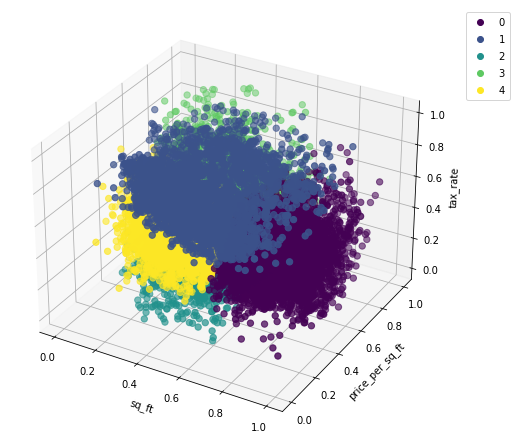

In [28]:
# The following command will make the graphic interactive
# but it creates problems for subsequent graphics and should be commented out 
# until it's being used

# %matplotlib notebook



# assigning the graphing data
x = deal_cluster_df.sq_ft
y = deal_cluster_df.price_per_sq_ft
z = deal_cluster_df.tax_rate
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)
# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
t = kmeans_deal_cluster_df.predict(deal_cluster_df)
# plot
# the x,y,z labels might need to be specific...
sc = ax.scatter(x, y, z, s=40, c=t, marker='o')#, cmap=t, alpha=1)
ax.set_xlabel('sq_ft')
ax.set_ylabel('price_per_sq_ft')
ax.set_zlabel('tax_rate')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')

...Now things seem to be working all of a sudden...but i have to run the cells twice (beginning with the one where i define kmeans_deal_cluster_df

- 3. green: small and expensive.  all tax rates
- 0. purple: large, represented across all other variables
- 2. sea green: small and cheap, low tax rate
- 4. yellow: small and cheap,  middle tax rates
- 1. lavender: small to medium and cheaper, high tax rates

In [34]:
X_train['cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

In [42]:
train['cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

<AxesSubplot:xlabel='county', ylabel='logerror'>

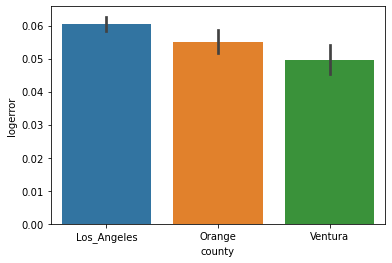

In [50]:
sns.barplot(x='county',y=df['logerror'].abs(),data=train)

Los_Angeles county has the worst logerror overall, though we're talking about small margins

<AxesSubplot:xlabel='county', ylabel='logerror'>

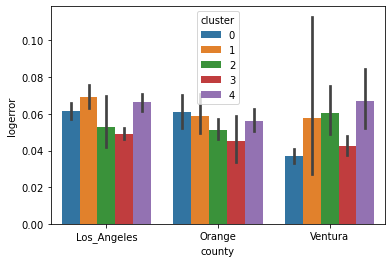

In [49]:
sns.barplot(x='county',y=df['logerror'].abs(),data=train,hue='cluster')

- Group 3 consistently has the least logerror, in all counties. That's small, expensive homes in all tax rates
- Group 2 (small and cheap, low taxes) is also consistently low, although things work differently in Ventura
    - In Ventura county, Group 0 (large homes in all price and tax ranges) have the lowest logerror

### Anova testing is called for here: